# 1. Data Cleaning & Variable Selection

First, we need to define the response variable to be used in our investment. For this, we look into the property of loan_status and last_pymnt_d variables. After defining the response variable, the dataset (by period) is selected accordingly.

For the next, the variables are selected by following process:

- 1) Get variables available in the test variables
- 2) Check the meaning of each selected variable and drop irrelevant ones
- 3) Check how many NAN are there for each variable in the training dataset
- 4) Drop variables with too many NAN
- 5) check distribution, outliers, NAN, possible transformation, etc.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import os

warnings.filterwarnings("ignore")
%matplotlib inline

os.chdir("/home/jacob/Project/LendingClub/")

In [70]:
def return_files():
    
    # get all list of csv and excel files
    directory = !pwd
    directory = directory[0]
    data_dir = directory + "/Data"
    files = !ls {data_dir}
    files = [f for f in files if ".zip" not in f]

    # divide by type
    dict_file = ["Data/" + f for f in files if "Dict" in f][0]
    training_files = ["Data/" + f for f in files if "LoanStats" in f]
    target_file = ["Data/" + f for f in files if "listed" in f][0]
    
    return dict_file, training_files, target_file

In [71]:
# get file names
dict_file, training_files, target_file = return_files()

## A. Defining response variable and selecting dataset

In [72]:
# get Quarter
def get_quarter(x): 
    if x.month<=3:
        return "Q1"
    elif x.month<=6:
        return "Q2"
    elif x.month<=9:
        return "Q3"
    else:
        return "Q4"

In [73]:
def get_transformed_data_for_reponse_var_anal(new_df):
    
    # bad loans
    bad_loans = ["Charged Off", "Default", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

    # True/False if status is bad_loans
    new_df["bad_loan"] = np.where(new_df["loan_status"].map(lambda x: x in bad_loans), True, False)

    # NAN if status is Current
    new_df["bad_loan"][new_df["loan_status"]=="Current"] = np.nan

    # change issue_d to datetime type
    new_df["issue_d"] = [datetime.datetime.strptime(d, "%b-%Y") for d in new_df["issue_d"] if type(d) is str]

    # change last_pymt_d to maximum date if it is NAN 
    ind = new_df["last_pymnt_d"].isna()
    dates = new_df["issue_d"][ind] + datetime.timedelta(36*30)
    dates = dates.map(lambda x: x.strftime("%b-%Y"))
    new_df["last_pymnt_d"][ind] = dates

    # change last_pymnt_d to datetime type
    new_df["last_pymnt_d"] = [datetime.datetime.strptime(d, "%b-%Y") for d in new_df["last_pymnt_d"] if type(d) is str]

    # get issuance quarter and year 
    new_df["issue_Q"] = new_df["issue_d"].map(get_quarter)
    new_df["issue_y"] = new_df["issue_d"].map(lambda x: x.year)

    # get month of becoming bad_loan from issuance
    new_df["month_bad_loan"] = np.nan

    ind = (new_df["bad_loan"]==1)
    new_df["month_bad_loan"][ind] = round((new_df["last_pymnt_d"][ind] - new_df["issue_d"][ind]).map(lambda x: x.days) / 30)

    return(new_df)

In [74]:
def get_response_var_anal_single_data(file, term):

    df = pd.read_csv(file, sep=",", skiprows=1)
    df = df[df["term"]== term] #" 36 months"
    
    # filter out unnecessary columns
    new_df = df[["loan_status", "last_pymnt_d", "issue_d", "grade", "sub_grade"]]
    
    # transform data
    new_df = get_transformed_data_for_reponse_var_anal(new_df)
    
    # return 
    return new_df

In [75]:
def get_response_var_anal_data(training_files, term):
    
    summary_data = []
    summary_grade = pd.DataFrame({})
    summary_grade_f = pd.DataFrame({})
    months_data = pd.DataFrame({})
    
    for file in training_files:
        
        # get transformed data
        print("Processing {}...".format(file))
        new_df = get_response_var_anal_single_data(file, term)
    
        # loop
        years = new_df["issue_y"].unique()
        quarters = new_df["issue_Q"].unique()

        for y in years:
            for q in quarters:

                temp = new_df[new_df["issue_y"]==y]
                temp = temp[temp["issue_Q"]==q]
                n = temp.shape[0]

                # loan_status
                summary = temp["loan_status"].value_counts()/n*100

                # number of issuance
                summary["n_issue"] = n

                # number of bad_loans
                summary["bad_loans"] = temp["bad_loan"].sum()/n*100
                
                # quarter/year
                summary["quarter"] = q
                summary["year"] = y
                
                summary_data.append(summary)

                # data - sumary grade (this is ratio for finalized loan only)
                n_grade = temp[["grade","sub_grade","bad_loan"]].groupby(["grade","sub_grade"]).agg("count")
                r_grade = temp[["grade","sub_grade","bad_loan"]].groupby(["grade","sub_grade"]).agg(np.sum)/n_grade*100
                
                # data - summary grade (the denominator here is the full datat inluding running loans)
                # runnng loan is traded as not defaulted
                n_grade_f = temp.fillna(0)[["grade","sub_grade","bad_loan"]].groupby(["grade","sub_grade"]).agg("count")
                r_grade_f = temp.fillna(0)[["grade","sub_grade","bad_loan"]].groupby(["grade","sub_grade"]).agg(np.sum)/n_grade_f*100
                
                if summary_grade.shape[0] == 0:
                    summary_grade = pd.DataFrame(r_grade)
                    summary_grade.columns = ["{}_{}".format(q,y)]
                else:
                    summary_grade["{}_{}".format(q,y)] = r_grade
                    
                if summary_grade_f.shape[0] == 0:
                    summary_grade_f = pd.DataFrame(r_grade_f)
                    summary_grade_f.columns = ["{}_{}".format(q,y)]
                else:
                    summary_grade_f["{}_{}".format(q,y)] = r_grade_f
                
        # data - months becoming bad loans
        months = new_df[new_df["bad_loan"]==1]
        months_data = months_data.append(months)

    summary_data = pd.DataFrame(summary_data)
    return summary_data, summary_grade, summary_grade_f, months_data

As a first step, let's get the summary of the dataset regarding to the loan status. The processed summary of the dataset are separated and saved to "summary_data", "summary_grade", and "months_data". The "summary_data" variable contains the loan status statistics at each quarter, while the "summary_grade" shows the loan status statistics by the loan grade. The dataset "months_data" is stored to track the actual time taken to be a bad loan. This information will be helpful define precisely our target response variable going foward. Please note, as of now, a bad loan is defined as a loan ends up in one of the following status: "charge off", "default, "delinquent", and "in grace period"

In [76]:
summary_data, summary_grade, summary_grade_f, months_data = get_response_var_anal_data(training_files, " 36 months")

Processing Data/LoanStats_2016Q1.csv...
Processing Data/LoanStats_2016Q2.csv...
Processing Data/LoanStats_2016Q3.csv...
Processing Data/LoanStats_2016Q4.csv...
Processing Data/LoanStats_2017Q1.csv...
Processing Data/LoanStats_2017Q2.csv...
Processing Data/LoanStats_2017Q3.csv...
Processing Data/LoanStats_2017Q4.csv...
Processing Data/LoanStats_2018Q1.csv...
Processing Data/LoanStats_2018Q2.csv...
Processing Data/LoanStats_2018Q3.csv...
Processing Data/LoanStats_2018Q4.csv...
Processing Data/LoanStats_2019Q1.csv...
Processing Data/LoanStats_2019Q2.csv...
Processing Data/LoanStats_2019Q3.csv...
Processing Data/LoanStats_2019Q4.csv...
Processing Data/LoanStats3a.csv...
Processing Data/LoanStats3b.csv...
Processing Data/LoanStats3c.csv...
Processing Data/LoanStats3d.csv...


As shown in the table and plot below, the origination of the loans rapidly grows from 2012. At the time of the analysis, the loans issued before Q1 2016 are all supposed to have final status (not current). Therefore, we can select the something between Q1 of 2012 and Q1 of 2016 as our final dataset. In order to discard too outdated data, the dataset until Q4 2013 are excluded. Moreover, since more than 50% of originated loans are already prepaid in Q2, Q3 and Q4 of 2016, those can also be included in our final dataset as well. 

Therefore, our final data points can be the loans which are issued between Q1 of 2014 and Q4 of 2016 while having final status. Let's take a look further on the other summaries.

In [77]:
# Please note rest of the dataset after Q4 2016 are also used as a out-of-time testset.

In [78]:
summary_data.sort_values(["year", "quarter"], inplace=True)
display(summary_data)

,Fully Paid,Charged Off,n_issue,bad_loans,quarter,year,Default,Current,Late (31-120 days),Late (16-30 days),In Grace Period,Does not meet the credit policy. Status:Fully Paid,Does not meet the credit policy. Status:Charged Off
loan_status,NaN,NaN,0.0,NaN,Q1,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_status,4.166667,NaN,24.0,0.000000,Q2,2007,NaN,NaN,NaN,NaN,NaN,83.333333,12.500000
loan_status,37.368421,5.263158,190.0,5.263158,Q3,2007,NaN,NaN,NaN,NaN,NaN,41.578947,15.789474
loan_status,34.447301,8.997429,389.0,8.997429,Q4,2007,NaN,NaN,NaN,NaN,NaN,35.989717,20.565553
loan_status,47.877591,9.476802,1013.0,9.476802,Q1,2008,NaN,NaN,NaN,NaN,NaN,29.022705,13.622902
loan_status,49.799197,8.835341,498.0,8.835341,Q2,2008,NaN,NaN,NaN,NaN,NaN,28.112450,13.253012
loan_status,53.020134,9.395973,298.0,9.395973,Q3,2008,NaN,NaN,NaN,NaN,NaN,29.530201,8.053691
loan_status,72.602740,13.527397,584.0,13.527397,Q4,2008,NaN,NaN,NaN,NaN,NaN,10.273973,3.595890
loan_status,76.201117,10.391061,895.0,10.391061,Q1,2009,NaN,NaN,NaN,NaN,NaN,10.055866,3.351955
loan_status,76.502732,11.384335,1098.0,11.384335,Q2,2009,NaN,NaN,NaN,NaN,NaN,9.107468,3.005464


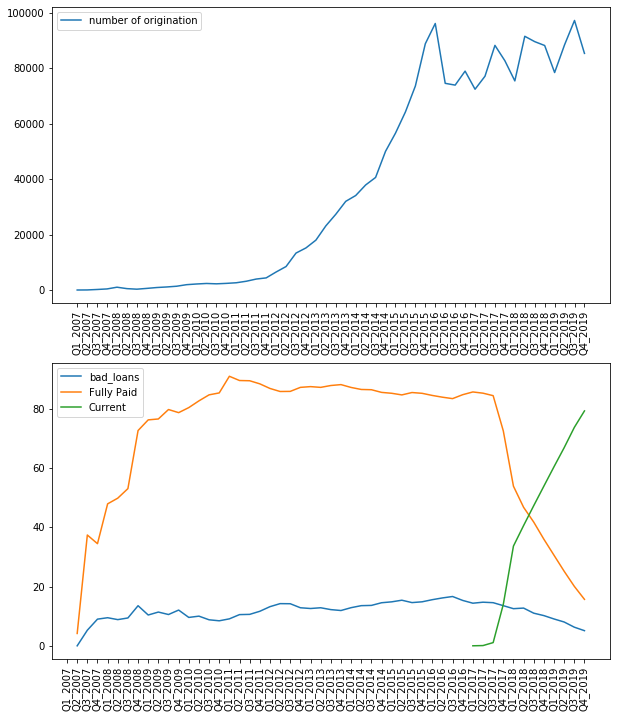

In [79]:
xs = ["_".join([str(x),str(y)]) for x, y in zip(summary_data["quarter"], summary_data["year"])]

fig = plt.figure(figsize=(10,12))
ax  = fig.add_subplot(2,1,1)
ax.plot(xs,summary_data["n_issue"])
ax.legend(["number of origination"])
plt.xticks(rotation=90)

ax = fig.add_subplot(2,1,2)
ax.plot(xs,summary_data["bad_loans"])
ax.plot(xs,summary_data["Fully Paid"])
ax.plot(xs,summary_data["Current"])
ax.legend(["bad_loans", "Fully Paid", "Current"])
plt.xticks(rotation=90)

fig.show()

The bad loan ration by each grades are analyzed for the next. As shown in the first pile of plots, the ratio of the high grade loans (below C) is monotonically and gradually increase by the grade for every quarters. However, it becomes relatively unstable as it goes to riskier loans.

In [80]:
# summary grade - exclude data until Q4_2013
summary_grade_f = summary_grade_f[xs[28:]]
summary_grade = summary_grade[xs[28:]]

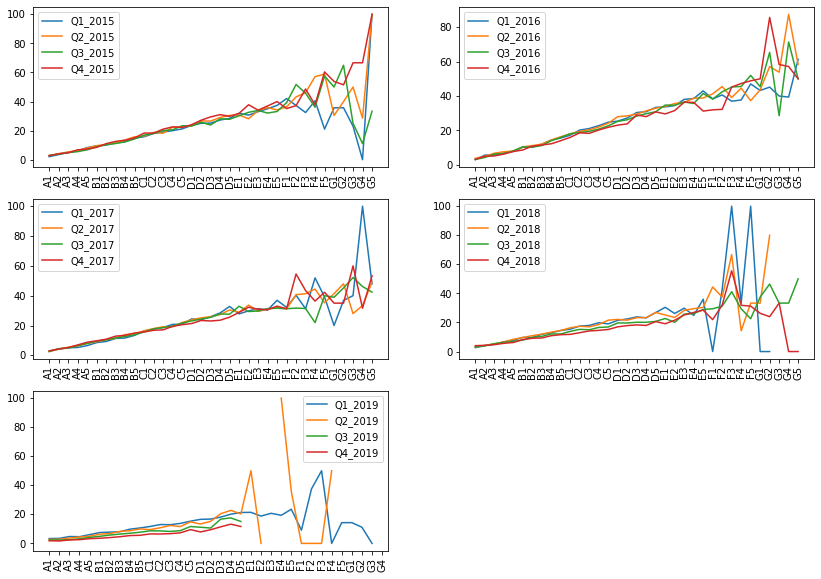

In [81]:
years = ["2015","2016","2017","2018","2019"]
cols = summary_grade_f.columns.values
subgs = summary_grade_f.index.get_level_values("sub_grade")

fig = plt.figure(figsize=(14,10))

for i, y in enumerate(years):
    temp_cols = [c for c in cols if y in c]
    ax = fig.add_subplot(3,2,i+1)
    for col in temp_cols:
        ax.plot(subgs,summary_grade_f[col])        
    ax.legend(temp_cols)
    plt.xticks(rotation=90)
fig.show()

The plots below are the important observations. The bad loan ratio is slightly increasing from Q4 2015. The ratio here represents the number of bad loans over the total originated loans. Note that the ratio at Q2 2016 is already higher than previous quarters, even with 35% live loans. This increase in recent loans can be caused either by lending club model deterioration or more risk in the market. It is not clear, and therefore, including the data in this recent period as much as possible in our training dataset will be crucial.

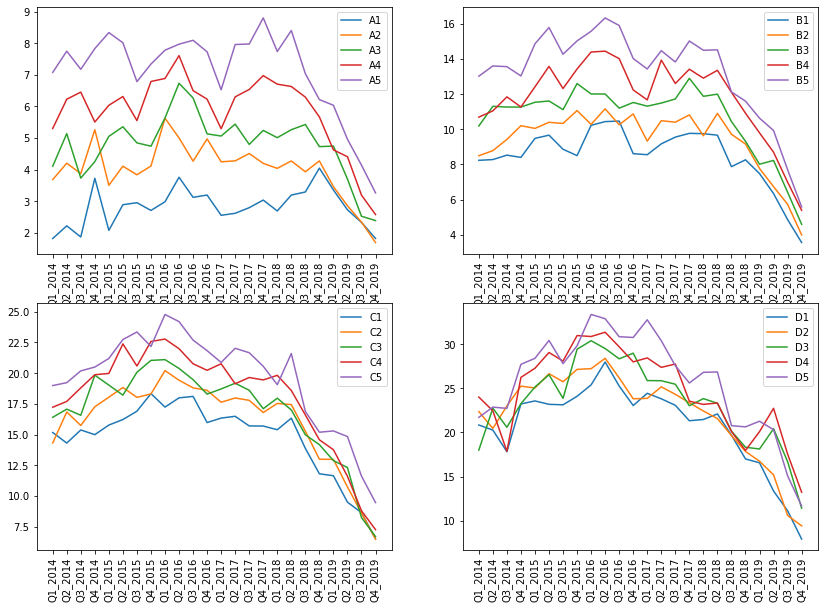

In [82]:
gs = ["A","B","C","D"]
fig = plt.figure(figsize=(14,10))
for i, g in enumerate(gs):
    temp_grades = [sg for sg in subgs if g in sg]
    
    ax = fig.add_subplot(2,2,i+1)
    for temp_g in temp_grades:
        ax.plot(summary_grade_f.loc[g].loc[temp_g])

    ax.legend(temp_grades)
    plt.xticks(rotation=90)
fig.show()

The increase in bad loans can be more clearly spotted in the plots below. The y-axis below represents the ratio of the number of bad loans over the total number of closed loans (not the total number of issed loans). There indeed is a large jump at 2016. 

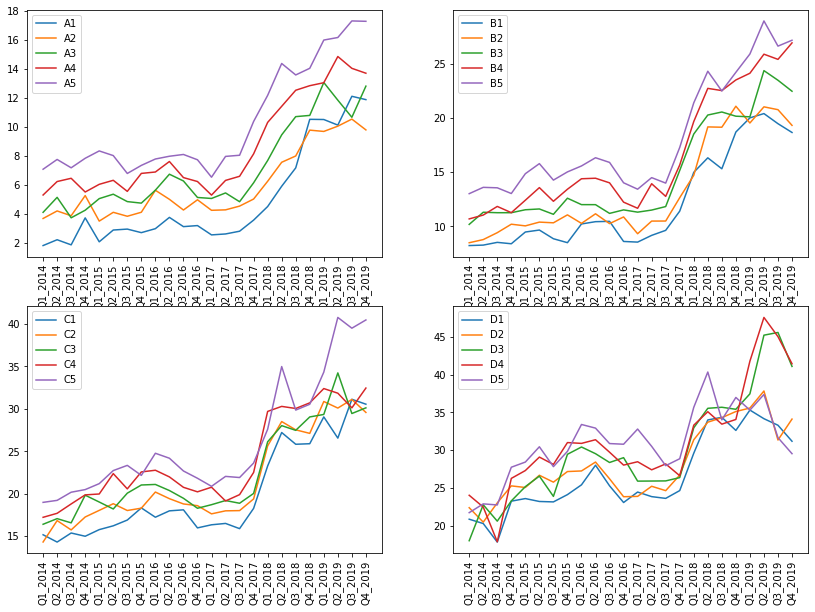

In [83]:
gs = ["A","B","C","D"]
fig = plt.figure(figsize=(14,10))
for i, g in enumerate(gs):
    temp_grades = [sg for sg in subgs if g in sg]
    
    ax = fig.add_subplot(2,2,i+1)
    for temp_g in temp_grades:
        ax.plot(summary_grade.loc[g].loc[temp_g])

    ax.legend(temp_grades)
    plt.xticks(rotation=90)
fig.show()
    

The plot below shows us a timing of default. Based on the plot, we need to define our reponse variable as a loan fallen into a bad status within 45 months after the origination. The months longer than the tenor (36m) is due to the grace period and delinquent period. We should not define our response variable with a shorter observing period.

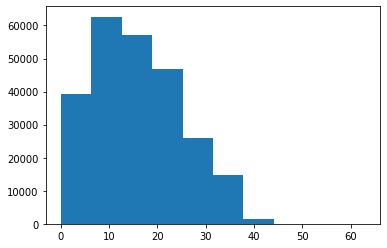

In [84]:
a = plt.hist(months_data["month_bad_loan"])

Based on these observations so far, we concluded the two following points:

- First, our response variable is defined as loan falling into a bad status within 45 months after an origination. Here, the bad status represents the one of following: default, charge-off, delinquent, and in grace period.

- Second, the dataset is selected as entire closed loans issued between Q1 2014 and Q2 2016. The closed loans after the period will be used as a out-of-bag validation dataset as well.

## B. Preparing explanatory variables

In [88]:
def read_dict_file(dict_file):
    data_dict = pd.read_excel(dict_file).dropna()
    data_dict.set_index('LoanStatNew', inplace=True)
    data_dict.sort_index(inplace=True)
    print("Reading {}..., {}".format(dict_file, data_dict.shape))
    
    return data_dict

In [89]:
def transform_training_raw_data(training_file, term):

    # read file
    df = pd.read_csv(training_file, sep=",", skiprows=1)
    df = df[df["term"]== term] #" 36 months"

    # change issue_d to datetime type
    df["issue_d"] = [datetime.datetime.strptime(d, "%b-%Y") for d in df["issue_d"] if type(d) is str]

    issue_Qs = df["issue_d"].map(get_quarter)
    issue_Ys = df["issue_d"].map(lambda x: x.year)
    
    if np.max(issue_Ys) < 2016:
        return pd.DataFrame()
    #elif np.min(issue_Ys) >= 2020:
    #    return pd.DataFrame()
    #elif np.min(issue_Ys)==2016 and np.min(issue_Qs) in ["Q3","Q4"]:
    #    return pd.DataFrame()

    # get issuance quarter and year 
    df["issue_Q"] = issue_Qs
    df["issue_y"] = issue_Ys
    
    # remove live loans
    df = df[df["loan_status"]!="Current"]
    
    # defined bad loan status
    bad_loans = ["Charged Off", "Default", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

    # True/False if status is bad_loans
    df["bad_loan"] = np.where(df["loan_status"].map(lambda x: x in bad_loans), True, False)

    # change last_pymt_d to maximum date if it is NAN 
    ind = df["last_pymnt_d"].isna() 
    dates = df["issue_d"][ind] + datetime.timedelta(36*30)
    dates = dates.map(lambda x: x.strftime("%b-%Y"))
    df["last_pymnt_d"][ind] = dates

    return df

In [90]:
def get_summary_raw_training_data(training_files, target_cols):
    
    data_summary = []
    info_columns = {}
    
    for file_name in training_files:
        
        print("Reading.. ", file_name)
        df = transform_training_raw_data(file_name, term = " 36 months")
        
        if df.shape == (0,0):
            print("..Out of period")
            continue
        
        min_d = np.min(df["issue_d"])
        max_d = np.max(df["issue_d"])   
        min_f = " ".join([get_quarter(min_d),str(min_d.year)])
        max_f = " ".join([get_quarter(max_d),str(max_d.year)])
        
        # data summary
        data_summary.append({"file_name":file_name, "rows":df.shape[0], "cols":df.shape[1], "min_f":min_f, "max_f":max_f})
        
        # get column NAN Count
        if max_d.year < 2016:
            f_key = "-".join([min_d.strftime("%b%y"), max_d.strftime("%b%y")])
        else:
            f_key = file_name[15:21]
        
        info_columns[f_key] = df.isna().sum()/df.shape[0]
    
    data_summary = pd.DataFrame(data_summary)
    data_summary = data_summary[["file_name","rows","cols","min_f","max_f"]]
    info_columns = pd.DataFrame(info_columns)
    
    # extend it to see the stat
    row_mean = info_columns.apply(np.mean,axis=1)
    row_min  = info_columns.apply(np.min,axis=1)
    row_max  = info_columns.apply(np.max,axis=1)

    info_columns["mean"] = row_mean
    info_columns["min"]  = row_min
    info_columns["max"]  = row_max
    info_columns["available"] = [col in target_cols for col in info_columns.index.values]
    
    return data_summary, info_columns

### Target csv file

We check which variables are available in the actual dataset for the prediction. This should be the starting point, since our goal is the actual investing leveraging the historical data. Therefore, the data (variable) filtering should start from the dataset availble for the listed loans.

In [124]:
# read
target_df = pd.read_csv(target_file, sep=",")

In [125]:
target_cols = target_df.columns.values
print(target_df.shape)

(62, 122)


First, let's see what we need to exclude manually. To do that we need to get the dictionary of variables.

In [126]:
# read dictionary file
data_dict = read_dict_file(dict_file)

Reading Data/LCDataDictionary.xlsx..., (151, 1)


In [127]:
# filter to the columns available in target_file
data_dict = data_dict.reindex(target_cols)
data_dict.shape

(122, 1)

In [128]:
target_df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate',
       'exp_default_rate', 'service_fee_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'is_inc_v', 'accept_d', 'exp_d', 'list_d',
       'credit_pull_d', 'review_status_d', 'review_status', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'msa',
       'acc_now_delinq', 'acc_open_past_24mths', 'bc_open_to_buy',
       'percent_bc_gt_75', 'bc_util', 'dti', 'delinq_2yrs', 'delinq_amnt',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'mths_since_recent_bc',
       'mort_acc', 'open_acc', 'pub_rec', 'total_bal_ex_mort',
       'revol_bal', 'revol_util', 'total_bc_limit', 'total_acc',
       'total_il_high_credit_limit', 'num_rev_accts',
       'mths_since_recent_bc_

By looking at the glossary, decided to remove the following unnecesary columns!

In [96]:
# we need to exclude this from the training dataset and also the target dataset
target_exclude_list = [
    # no meaning can be found  
    "exp_default_rate", "service_fee_rate", "accept_d", "exp_d", "credit_pull_d", "review_status_d", "msa", "initial_list_status", 
    "ils_exp_d", "housing_payment", "revol_bal_joint", "sec_app_fico_range_low", "sec_app_fico_range_high",
    "sec_app_earliest_cr_line", "sec_app_inq_last_6mths", "sec_app_mort_acc",  "sec_app_open_acc",
    "sec_app_revol_util", "sec_app_open_act_il", "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths",              
    "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog", "funded_amnt",
    
    # irrelevant or duplicated
    "emp_title", "term", "grade", "initial_list_status", "disbursement_method", "zip_code", "title"
]

# will not be used for the prediction, but used in the process
target_info_list = ["id", "member_id", "url"]

In [97]:
# drop the exclusion list - 92 variables are left
target_df.drop(target_exclude_list, axis=1, inplace=True)
target_df.drop(target_info_list, axis=1, inplace=True)
target_df.shape

(62, 89)

### Training Dataset

We check the meaning of each selected variables in the step above and drop irrelevant ones based on the meaning. We also check how many missing variables are there for each selected variable in the training dataset. If the ratio is more than 20%, then we drop the variables from the candidates. 

In [129]:
target_cols = target_df.columns.values

In [130]:
# manually set this - this will be used to check the final status (y variable)
y_var = "bad_loan"
training_info_list = ["last_pymnt_d", "loan_status"]

In [131]:
# get high level summary of each dataset
# get stat of NAN data points for each variables + whether it is in the target dataset
data_summary, info_columns = get_summary_raw_training_data(training_files, target_cols)

Reading..  Data/LoanStats_2016Q1.csv
Reading..  Data/LoanStats_2016Q2.csv
Reading..  Data/LoanStats_2016Q3.csv
Reading..  Data/LoanStats_2016Q4.csv
Reading..  Data/LoanStats_2017Q1.csv
Reading..  Data/LoanStats_2017Q2.csv
Reading..  Data/LoanStats_2017Q3.csv
Reading..  Data/LoanStats_2017Q4.csv
Reading..  Data/LoanStats_2018Q1.csv
Reading..  Data/LoanStats_2018Q2.csv
Reading..  Data/LoanStats_2018Q3.csv
Reading..  Data/LoanStats_2018Q4.csv
Reading..  Data/LoanStats_2019Q1.csv
Reading..  Data/LoanStats_2019Q2.csv
Reading..  Data/LoanStats_2019Q3.csv
Reading..  Data/LoanStats_2019Q4.csv
Reading..  Data/LoanStats3a.csv
..Out of period
Reading..  Data/LoanStats3b.csv
..Out of period
Reading..  Data/LoanStats3c.csv
..Out of period
Reading..  Data/LoanStats3d.csv
..Out of period


In [132]:
data_summary

,file_name,rows,cols,min_f,max_f
0,Data/LoanStats_2016Q1.csv,96120,153,Q1 2016,Q1 2016
1,Data/LoanStats_2016Q2.csv,74537,153,Q2 2016,Q2 2016
2,Data/LoanStats_2016Q3.csv,73898,153,Q3 2016,Q3 2016
3,Data/LoanStats_2016Q4.csv,78940,153,Q4 2016,Q4 2016
4,Data/LoanStats_2017Q1.csv,72401,153,Q1 2017,Q1 2017
5,Data/LoanStats_2017Q2.csv,77039,153,Q2 2017,Q2 2017
6,Data/LoanStats_2017Q3.csv,87270,153,Q3 2017,Q3 2017
7,Data/LoanStats_2017Q4.csv,71128,153,Q4 2017,Q4 2017
8,Data/LoanStats_2018Q1.csv,50048,153,Q1 2018,Q1 2018
9,Data/LoanStats_2018Q2.csv,54395,153,Q2 2018,Q2 2018


In [133]:
info_columns.shape

(153, 20)

In [134]:
# filter out the columns which is not available in the target_file
filtered = info_columns[info_columns["available"]]
filtered.shape

(106, 20)

In [135]:
filtered[filtered["min"] >= 0.2]

,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,mean,min,max,available
member_id,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True
desc,0.999938,0.999933,0.999946,0.999987,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999988,0.999933,1.000000,True
mths_since_last_delinq,0.476706,0.473724,0.459431,0.461654,0.478667,0.484092,0.489790,0.542220,0.559883,0.548617,0.544057,0.552535,0.557015,0.550530,0.545806,0.554390,0.517445,0.459431,0.559883,True
mths_since_last_record,0.817873,0.808511,0.798614,0.795592,0.802834,0.804151,0.846671,0.848217,0.850843,0.863811,0.865605,0.864674,0.866744,0.876785,0.880584,0.883268,0.842174,0.795592,0.883268,True
mths_since_last_major_derog,0.708968,0.714061,0.700127,0.701647,0.717780,0.719285,0.724132,0.750141,0.763707,0.754628,0.755028,0.760390,0.764886,0.763455,0.765581,0.769582,0.739587,0.700127,0.769582,True
annual_inc_joint,0.984103,0.988315,0.995683,0.968330,0.963647,0.951726,0.913017,0.882297,0.875000,0.887876,0.885803,0.890530,0.885873,0.883738,0.887262,0.896859,0.921254,0.875000,0.995683,True
dti_joint,0.984124,0.988315,0.995683,0.968330,0.963647,0.951726,0.913017,0.882297,0.875000,0.887876,0.885803,0.890530,0.885873,0.883738,0.887262,0.896859,0.921255,0.875000,0.995683,True
mths_since_recent_bc_dlq,0.744361,0.743819,0.734959,0.741956,0.754437,0.757045,0.760089,0.790125,0.799093,0.794944,0.791400,0.796446,0.794996,0.788711,0.785106,0.786218,0.772732,0.734959,0.799093,True
mths_since_recent_revol_delinq,0.637568,0.635966,0.627324,0.631619,0.642726,0.646750,0.650900,0.696674,0.709978,0.703098,0.698543,0.703984,0.703636,0.695286,0.691425,0.699487,0.673435,0.627324,0.709978,True
revol_bal_joint,1.000000,1.000000,1.000000,1.000000,0.992030,0.951778,0.913017,0.882311,0.875000,0.887876,0.885803,0.890530,0.885873,0.883738,0.887262,0.896859,0.927005,0.875000,1.000000,True


In [107]:
# filter out the columns if there are too many NANs
filtered = filtered[filtered["min"] < 0.2]
filtered.shape

(75, 20)

After the filterings, there are 75 variables left. The following variables are added back, since it might be usable with a proper data transformation; the missing point in variales does not indicate true missing, but indicate 0 default or delinquenct, which can be useful information for the prediction.

In [108]:
# manually incldue following variables, since it might be useful if we process data properly
training_additional_include_list = ["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog",
                                   "mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq"]

In [109]:
interim_cols = filtered.index.values
interim_cols = list(interim_cols) + training_additional_include_list

In [110]:
len(interim_cols)

80

### Getting back to Target Data

Let's quickly check how many missing variables are there in the taget dataset for our 78 variales selected.


In [111]:
# check whether the target data has too many NAN on the selected variables or not.
counts = target_df[interim_cols].isna().sum()
counts[counts>0]

emp_length                      5
mths_since_last_major_derog    43
dtype: int64

In [39]:
# Penalty as 0 if some has no employment length

In [40]:
# we have selected 78 explanatory variables so far.
# now, we need to find the way to clean and transform the data!

## Save Interim Results

In [41]:
info_cols = ['id', 'loan_status', 'issue_d', "issue_Q", "issue_y", "bad_loan", "return", "log_return",
             'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt']

In [42]:
results = {}
results["info_cols"] = info_cols
results["interim_cols"] = interim_cols

In [43]:
results["missing_cols"] = ["num_tl_120dpd_2m", "emp_length", "inq_last_12m", "inq_fi", "max_bal_bc", "open_rv_24m",
                       "open_rv_12m", "total_cu_tl", "total_bal_il", "open_il_24m", "open_il_12m", "open_act_il",
                       "open_acc_6m", "all_util", "mths_since_rcnt_il", "il_util", "mths_since_last_record"]

In [44]:
results["no_missing_cols"] = [x for x in results["interim_cols"] if x not in results["missing_cols"]]

In [114]:
import json

In [46]:
with open("Data/variable_selected.txt", 'w') as f:
    json.dump(results, f)

In [3]:
!pwd

/home/jacob/Project/LendingClub/Notebook
